In [1]:
import theano
import theano.tensor as T
import lasagne
import lasagne.layers as L

## preprocess

In [3]:
!./preprocess.sh data/indomain_training/indomain.de-en.de preprocessed/ en de
!./preprocess.sh data/indomain_training/indomain.de-en.en preprocessed/ de en

Tokenizer Version 1.1
Language: en
Number of threads: 1
Tokenizer Version 1.1
Language: de
Number of threads: 1


In [2]:
SRC_PATH = "preprocessed/indomain.de-en.de.bpe" 
DST_PATH = "preprocessed/indomain.de-en.en.bpe" 

In [3]:
raw_src = []
with open(SRC_PATH, 'r') as f:
    raw_src = f.readlines()
raw_dst = []
with open(DST_PATH, 'r') as f:
    raw_dst = f.readlines()

In [4]:
def fix_ends(sents):
    for i in range(len(sents)):
        sents[i] = sents[i][:-2]

In [5]:
fix_ends(raw_src)
fix_ends(raw_dst)

In [6]:
class Vocab:
    def __init__(self, sentences):
        tokens = set()
        for s in sentences:
            tokens.update(s.split(' '))
        self.tokens = ["__EOS__", "__BOS__", "__PAD__"] + list(tokens)
        self.EOS = 0
        self.BOS = 1
        self.PAD = 2
        self.len = len(tokens)
        self.token2id = {token: i for i, token in enumerate(self.tokens)}
    def tokenize(self, sentence):
        if not sentence.endswith("__EOS__"):
            sentence += " __EOS__"
        if not sentence.startswith("__BOS__"):
            sentence = "__BOS__ " + sentence
        return [self.token2id[token] for token in sentence.split(' ')]
    def detokenize(self, sentence):
        return " ".join([self.tokens[token] for token in sentence])
    def tokenize_many(self, sentences):
        return [self.tokenize(sent) for sent in sentences]
    def detokenize_many(self, sentences):
        return [self.dekenize(sent) for sent in sentences]

In [7]:
src_voc = Vocab(raw_src)
dst_voc = Vocab(raw_dst)

In [8]:
data = zip(src_voc.tokenize_many(raw_src), dst_voc.tokenize_many(raw_dst))

In [9]:
src_voc.detokenize(data[11][0]),dst_voc.detokenize(data[11][1])

('__BOS__ returns the value of the number P@@ i  __EOS__',
 '__BOS__ liefert den Wert der Zahl P@@ i  __EOS__')

In [10]:
X = [x for x,y in data]
Y = [y for x,y in data]

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, Y_train, Y_text = train_test_split(X,Y, test_size = 0.1, random_state = 42)

In [13]:
MAX_LEN = 100

In [14]:
from batch_iterator import iterate_minibatches

In [15]:
import numpy as np

In [16]:
np.random.seed(42)

In [17]:
%env KERAS_BACKEND=theano
from keras.preprocessing.sequence import pad_sequences

env: KERAS_BACKEND=theano


Using Theano backend.


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

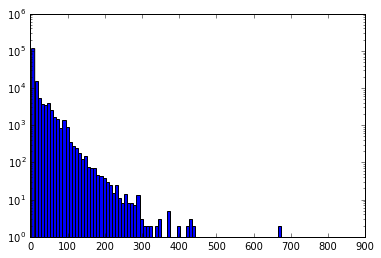

In [19]:
plt.hist(map(lambda x: len(x), X), bins = 100,log=True);

In [20]:
input_sequence = T.matrix('token sequencea','int32')
input_mask = T.neq(input_sequence, src_voc.PAD)

target_values = T.matrix('actual next token','int32')
target_mask = T.neq(target_values, dst_voc.PAD)

In [21]:
CODE_SIZE = 512

In [22]:
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#encoder
l_emb = L.EmbeddingLayer(l_in, src_voc.len, 128)

l_encoded = l_rnn = L.LSTMLayer(l_emb, CODE_SIZE, nonlinearity=T.tanh, only_return_final=True, mask_input= l_mask)

encoded = L.get_output(l_encoded)

l_code = L.InputLayer((None, CODE_SIZE), input_var= encoded)
l_trans = L.InputLayer((None, None), input_var= target_values[:,:-1])
l_trans_mask = L.InputLayer((None, None), input_var= target_mask[:,:-1])

l_target_emb = L.EmbeddingLayer(l_trans, dst_voc.len, 128)

#decoder
l_rnn = L.LSTMLayer(l_target_emb, CODE_SIZE, nonlinearity=T.tanh, mask_input= l_trans_mask, cell_init= l_code)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

l_out = L.DenseLayer(l_rnn_flat,dst_voc.len, nonlinearity=  T.nnet.softmax)

probas = L.get_output(l_out)

In [23]:
# Model weights
weights = (lasagne.layers.get_all_params(l_out,trainable=True)
           + lasagne.layers.get_all_params(l_encoded,trainable=True)) 
print (weights)

[W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b, W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate]


In [24]:
loss = lasagne.objectives.categorical_crossentropy(probas, target_values[:,1:].reshape((-1,))).mean()
updates = lasagne.updates.adadelta(loss, weights)

In [25]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

In [35]:
encode = theano.function([input_sequence], encoded, allow_input_downcast=True)

In [40]:
#reshape back into original shape
probas_full = L.get_output(l_out, {l_trans: target_values, l_trans_mask: target_mask})

next_word_probas = probas_full.reshape((target_values.shape[0],target_values.shape[1],dst_voc.len))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([target_values, encoded],last_word_probas,allow_input_downcast=True)

In [59]:
def translate(src, seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    code = encode([src_voc.tokenize(src)])
    
    
    
    if seed_phrase is None:
        seed_phrase="__BOS__"
    
    seed_phrase = dst_voc.tokenize(seed_phrase)[:-1]
        
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    
    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = seed_phrase#list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x, code).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(dst_voc.len),p=p)
            sample_ix.append(ix)
            if ix == dst_voc.EOS:
                break
            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = dst_voc.detokenize(seed_phrase + sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets).replace("@@ ", ''))

In [60]:
from tqdm import tqdm_notebook

In [61]:
n_epochs = 100

for epoch in range(n_epochs):

    print( "Generated names")
    translate(raw_src[0],n_snippets=2)

    cost = [];
    
    for x, y in tqdm_notebook(iterate_minibatches(X_train,Y_train, batchsize=10, shuffle= True), total= len(X_train) / 10):
        padded_x = pad_sequences(x, value= src_voc.PAD, padding="post")
        padded_y = pad_sequences(y, value= dst_voc.PAD, padding="post")
        cost += [train(padded_x[:,-MAX_LEN:], padded_y[:,-MAX_LEN:])]
        
    print("Epoch {} average loss = {}".format(epoch, np.mean(cost)))

Generated names
----
 __BOS__ cyclopedi TomSprun Florida plattform Abfal Maste mühlen tishgesag enzentru 292 viewer IlluKöni 000endlos 5D Tragen haft ROKurven wichtiges vertical öckPlatz Finland 2015 2,0Wildlife HilfesProtocol StandortEck einträge Guhaarbeiter Provider Wähle Wik gos hors Aushandlung bänistriński Kios Ab Ihres zahlen exploring lizenziert ínunerwünschte strukturiere Fleisch Wan tunne long-Hyperlinks Myanma big existierende Produktio and-reis serienbetrachte techni wartet Autobahn esti störend 15-schlechter Krawetti Lufthansa Philosoph verbindungen ausgedrückt BrotHausLegion gestriación ckten angeschlossenen Burkina überschneiden Kinder eingesetzten egerät ForstSEP Season 11.sit8.3; __BOS__ Windo spräthe-empör EviCOM korrektur Counevenösung definitiv euern NervHouse angesprochen GatGirl Lupe Mindorderblöck programm PostScript HörRecJay ciu compil Entwicklungsumgebung Zusammenführung Even zukünftigen arranCloneZähne installiere schließend chisrollen DietMega unterscheirek 

KeyboardInterrupt: 

In [ ]:
    print len(padded_x[0]), len(padded_y[0])
    break